In [1]:
#Imports

### Unfortunately, UMAP takes a while to import. One of its dependencies (pynndescent) uses numba, 
### which is the cause of the performance bottleneck here.

import cv2
import hdbscan
import json 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import skimage 
import umap
import umap.plot

from bokeh.embed import json_item
from bokeh.models import HoverTool
from bokeh.models.tools import LassoSelectTool
from bokeh.plotting import show as bokeh_show, output_notebook
from glob import glob
from joblib import dump, load
from hdbscan import HDBSCAN
from IPython.display import display, HTML, Image, Javascript
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
%matplotlib inline

In [321]:
#Constants
IMG_SIZE = 128
IMAGES_DIR = '../images/final_pigmentation_catalogue_2016'
TARGET_IMAGES_DIR = '../images/final_to_match'
MAX_FILES = 9999999

We visualise the images

In [322]:
def preprocess_image(file):
    fig, axs = plt.subplots(1, 2, constrained_layout = False)
    image = cv2.imread(file)
    axs[0].imshow(image)
    axs[0].set_title("pre")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.normalize(image,  np.zeros((IMG_SIZE,IMG_SIZE)), 0, 255, cv2.NORM_MINMAX)
    #image = cv2.bilateralFilter(image, 9, 50, 50)
    #image = cv2.fastNlMeansDenoising(image, None, 10)
    #image = cv2.GaussianBlur(image, (5, 5), 0)
    
#     _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     img_contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
#     img_contours = sorted(img_contours, key=cv2.contourArea)

#     for i in img_contours:
#         if cv2.contourArea(i) > 100: break
    
#     mask = np.zeros(image.shape[:2], np.uint8)
#     cv2.drawContours(mask, [i],-1, 255, -1)
#     image = cv2.bitwise_and(image, image, mask=mask)
    
    axs[1].imshow(image, cmap='gray')
    axs[1].set_title("post")
    plt.show()

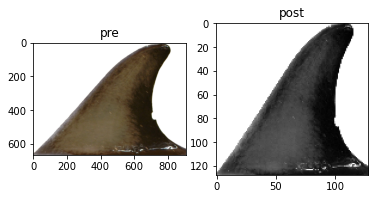

In [323]:
preprocess_image(f"{IMAGES_DIR}/0004/HG_131115_504_E4_KR_AII_N93.png")

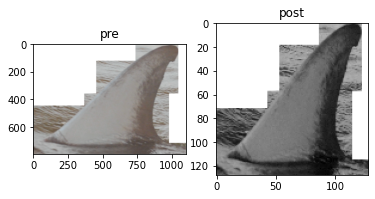

In [324]:
preprocess_image(f"{IMAGES_DIR}/0548/HG_130720_0360_E1_CL_AII.png")

We load the labelled images.

In [349]:
image_dirs = Path(IMAGES_DIR) 

labels = []
image_files = []

for image_dir in image_dirs.glob('*'):
    label = image_dir.stem
    for file in image_dir.glob('*'):
        #ext = file.suffix.lower()
        #if ext != ".png": continue
        image_files.append(file)
        labels.append(label)

In [364]:
image_file_len = len(image_files)
image_file_len

3746

In [351]:
y_encoder = LabelEncoder()
y_encoder.fit(labels)
y_target = y_encoder.transform(labels)
set(y_target)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [418]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_files, y_target, test_size=0.2, random_state=100, shuffle = True, stratify = y_target)

Then we apply additional pre-processing.

In [346]:
X_test[0:5]

[PosixPath('../images/final_pigmentation_catalogue_2016/0009/HG_130208_1860_E4_KR_AII.png'),
 PosixPath('../images/final_pigmentation_catalogue_2016/0830/HG_120713_049_E1_KR.png'),
 PosixPath('../images/final_pigmentation_catalogue_2016/0785/HG_131003_0553_E2_CL_AII.png'),
 PosixPath('../images/final_pigmentation_catalogue_2016/0521/HG_130210_1929_E2_KR_AII_N54.png'),
 PosixPath('../images/final_pigmentation_catalogue_2016/0807/HG_131003_0475_E2_CL_AII.png')]

In [358]:
Path(f"{IMAGES_DIR}_processed").mkdir(parents=True, exist_ok=True)
for label in set(labels):
    Path(f"{IMAGES_DIR}_processed/{label}").mkdir(parents=True, exist_ok=True)

In [ ]:
images = []
names = []
files = []

final_pigmentation_catalogue_2016_text = '../images/final_pigmentation_catalogue_2016.txt'
open(final_pigmentation_catalogue_2016_text, 'w').close()
f = open(final_pigmentation_catalogue_2016_text,'w')

for i, file in enumerate(image_files):
    saved_file = f"{IMAGES_DIR}_processed/{labels[i]}/{file.stem}.txt"
    file_str = str(file)
    f.write(file_str + '\n')
    names.append(file.stem)
    files.append(file_str)
    print(file_str)
    print(i)
    if os.path.isfile(saved_file): 
        image = np.loadtxt(saved_file)
        images.append(image)
        continue

    image = cv2.imread(file_str)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.normalize(image,  None, 0, 255, cv2.NORM_MINMAX)
    image = image.astype('float32')
    #image = cv2.GaussianBlur(image,(5,5),0)
    #image = cv2.bilateralFilter(image, 9, 50, 50)
    
    np.savetxt(saved_file, image, fmt='%d')
    images.append(image)
    progress = i/image_file_len * 100
    if progress % 5 == 0: print(f'{progress}% done')
        
f.close()
print("Complete!")

../images/final_pigmentation_catalogue_2016/0548/HG_110923_100_E2_N3.png
0
../images/final_pigmentation_catalogue_2016/0548/HG_130711_093_E4_CL_N7.png
1
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0333_E1_CL_AII.png
2
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0334_E1_CL_AII.png
3
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0359_E1_CL_AII.png
4
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0360_E1_CL_AII.png
5
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0361_E1_CL_AII.png
6
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0362_E1_CL_AII.png
7
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0363_E1_CL_AII.png
8
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0462_E1_KR_AII.png
9
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0463_E1_KR_AII.png
10
../images/final_pigmentation_catalogue_2016/0548/HG_130720_0502_E1_KR_AII.png
11
../images/final_pigmentation_catalogue_2016/0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



../images/final_pigmentation_catalogue_2016/0627/HG_130209_075_E1_NA.png
100
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-438-ebc3e279fa4b>", line 18, in <module>
    image = np.loadtxt(saved_file)
  File "/opt/conda/lib/python3.8/site-packages/numpy/lib/npyio.py", line 1146, in loadtxt
    for x in read_data(_loadtxt_chunksize):
  File "/opt/conda/lib/python3.8/site-packages/numpy/lib/npyio.py", line 997, in read_data
    items = [conv(val) for (conv, val) in zip(converters, vals)]
  File "/opt/conda/lib/python3.8/site-packages/numpy/lib/npyio.py", line 997, in <listcomp>
    items = [conv(val) for (conv, val) in zip(converters, vals)]
  File "/opt/conda/lib/python3.8/site-packages/numpy/lib/npyio.py", line 734, in floatconv
    return float(x)
KeyboardInterrupt

During handling of the above exception, another excep

TypeError: object of type 'NoneType' has no len()

In [366]:
np_test = np.loadtxt(f"{IMAGES_DIR}_processed/0548/HG_110923_100_E2_N3.txt" )
np_test

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [ 46.,  33.,  24., ...,  22., 100., 205.],
       [ 26.,  26.,  18., ...,  26.,  20.,  25.],
       [ 21.,  18.,  19., ...,  32.,  30.,  18.]])

The image data is converted into a numpy array.

In [433]:
images = np.asarray(images)
images.shape

(374, 128, 128)

Then flattened into 2D.

In [434]:
data = images.reshape((images.shape[0], -1))
#data = StandardScaler().fit_transform(data)
data.shape

(374, 16384)

In [372]:
np.savetxt('../images/final_pigmentation_catalogue_2016_data.txt', data, fmt='%d')

UMAP will be fitted to the data. This time, the class labels will be provided.

A collection of all the class labels:

In [435]:
mapper = umap.UMAP(
    n_neighbors = 200,
    min_dist = 0.5,
    n_components = 2,
    metric = 'euclidean',
    random_state = 100,
    densmap = False
).fit(data, y = y_train)

umap_res = mapper.transform(data)

In [ ]:
dump(mapper, 'umap_individual.joblib') 

We apply HDBSCAN to the UMAP results.

In [428]:
cluster = HDBSCAN(
    algorithm ='best', 
    approx_min_span_tree = True,
    gen_min_span_tree = False, 
    leaf_size = 40, 
    metric='euclidean', 
    min_cluster_size = 10,
    min_samples = 10, 
    p = None
).fit(umap_res)

In [429]:
hover_data = pd.DataFrame(
    index = np.arange(
        data.shape[0] 
    ), 
    data = {
        'index' : np.arange(data.shape[0]),
        'name': names,
        "file": files,
        "identity": y_train,
        'cluster_class': cluster.labels_,
        'probability': cluster.probabilities_,
        'outlier': [ 1 if item == -1 else 0 for item in cluster.labels_ ]
    }
)

In [ ]:
hover_data.head(10).drop("index", axis = 1)

In [436]:
hover = HoverTool(
    tooltips="""
    <div>
        <div>
            <img
                src="@file" height="128" alt="@file" width="128"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 10px; font-weight: bold;">@name</span>
            <span style="font-size: 10px; color: #966;">[$index]</span>
        </div>
        <div>
            <span style="font-size: 9px; color: #966;">@file</span>
        </div>
        <div>
            <span style="font-size: 9px; color: #966;">Identity: @identity</span>
        </div>
        <div>
            <span style="font-size: 9px; color: #966;">Probability: @probability</span>
        </div>
        <div>
            <span style="font-size: 9px; color: #966;">Outlier: @outlier</span>
        </div>
    </div>
    """
)

In [437]:
p = umap.plot.interactive(mapper, labels = y_train,hover_data = hover_data, point_size = 5, interactive_text_search = False)
del p.tools[len(p.tools)-1]
p.add_tools(hover)
p.add_tools(LassoSelectTool())
output_notebook()
bokeh_show(p)

Loading BokehJS ...

The front-end has been built using Vue.js. Therefore, the data must be consumable using a JS-friendly format. We can convert the Bokeh plot into a JSON blob, and visualise it using Bokeh.js. 

In [15]:
p_json = json.dumps(json_item(p))
p_json[0:150]

'{"target_id": null, "root_id": "1004", "doc": {"defs": [], "roots": {"references": [{"attributes": {"callback": null, "tooltips": "\\n    <div>\\n      '

In [16]:
display(HTML('<div id="umap"></div>'))
Javascript(f'''Bokeh.embed.embed_item({p_json}, "umap")''')

<IPython.core.display.Javascript object>

Now, we want to apply UMAP to the unlabelled data.

In [408]:
sup_files = Path(TARGET_IMAGES_DIR) 
sup_image_files = []

for file in sup_files.rglob('*'):
    ext = file.suffix.lower()
    if ext == ".jpg": sup_image_files.append(file)
    if len(sup_image_files) >= MAX_FILES: break
    
sup_image_files[0:4]

[PosixPath('../images/final_to_match/HG_161020_047_AM_N9.JPG'),
 PosixPath('../images/final_to_match/HG_161020_052_AM_P5.JPG'),
 PosixPath('../images/final_to_match/HG_161020_062_AM_N8.JPG'),
 PosixPath('../images/final_to_match/HG_161020_071_AM_N7.JPG')]

In [409]:
sup_images = []
sup_names = []
sup_files = []

for i, file in enumerate(sup_image_files):
    file_str = str(file)
    image = cv2.imread(file_str)
    sup_names.append(file.stem)
    sup_files.append(file_str)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    #image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
    image = image.astype('float32')
    #image = (image - image.mean(axis=(0, 1), keepdims = True)) / image.std(axis=(0, 1), keepdims = True)
    
    sup_images.append(image)
    
    progress = i/MAX_FILES * 100
    if progress % 5 == 0: print(f'{progress}% done')
        
print("Complete!")

0.0% done
Complete!


In [410]:
sup_images = np.asarray(sup_images)
sup_images.shape

(422, 128, 128)

In [411]:
sup_data = sup_images.reshape((sup_images.shape[0], -1))
#data = StandardScaler().fit_transform(data)
sup_data.shape

(422, 16384)

In [412]:
sup_umap_res = mapper.transform(sup_data)

In [413]:
sup_cluster = HDBSCAN(
    algorithm ='best', 
    approx_min_span_tree = True,
    gen_min_span_tree = False, 
    leaf_size = 40, 
    metric='euclidean', 
    min_cluster_size = 15,
    min_samples = 15, 
    p = None
).fit(sup_umap_res)

In [414]:
sup_umap_res.shape

(422, 2)

In [415]:
sup_hover_data = pd.DataFrame(
    index = np.arange(
        sup_data.shape[0] 
    ), 
    data = {
        'index' : np.arange(sup_data.shape[0]),
        'name': sup_names,
        "file": sup_files,
        'class': sup_cluster.labels_,
        'probability': sup_cluster.probabilities_,
        'outlier': [ 1 if item == -1 else 0 for item in sup_cluster.labels_ ]
    }
)

In [25]:
sup_hover_data.head(10).drop("index", axis = 1)

,name,file,class,probability,outlier
0,HG_161020_047_AM_N9,../images/final_to_match/HG_161020_047_AM_N9.JPG,1,0.554439,0
1,HG_161020_052_AM_P5,../images/final_to_match/HG_161020_052_AM_P5.JPG,-1,0.000000,1
2,HG_161020_062_AM_N8,../images/final_to_match/HG_161020_062_AM_N8.JPG,-1,0.000000,1
3,HG_161020_071_AM_N7,../images/final_to_match/HG_161020_071_AM_N7.JPG,-1,0.000000,1
4,HG_161023_220_AM_N1,../images/final_to_match/HG_161023_220_AM_N1.JPG,-1,0.000000,1
5,HG_161023_222_AM_N2,../images/final_to_match/HG_161023_222_AM_N2.JPG,-1,0.000000,1
6,HG_161023_224_AM_N4,../images/final_to_match/HG_161023_224_AM_N4.JPG,0,0.728885,0
7,HG_161023_246_AM_P8,../images/final_to_match/HG_161023_246_AM_P8.JPG,1,0.716484,0
8,HG_161023_250_AM_N5,../images/final_to_match/HG_161023_250_AM_N5.JPG,1,0.813304,0
9,HG_161023_257_AM_P1,../images/final_to_match/HG_161023_257_AM_P1.JPG,2,1.000000,0


In [416]:
hover = HoverTool(
    tooltips="""
    <div>
        <div>
            <img
                src="@file" height="128" alt="@file" width="128"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 10px; font-weight: bold;">@name</span>
            <span style="font-size: 10px; color: #966;">[$index]</span>
        </div>
        <div>
            <span style="font-size: 9px; color: #966;">@file</span>
        </div>
        <div>
            <span style="font-size: 9px; color: #966;">Class: @class</span>
        </div>
        <div>
            <span style="font-size: 9px; color: #966;">Probability: @probability</span>
        </div>
        <div>
            <span style="font-size: 9px; color: #966;">Outlier: @outlier</span>
        </div>
    </div>
    """
)

In [417]:
sup_mapper = umap.UMAP()
sup_mapper.embedding = sup_umap_res
p = umap.plot.interactive(sup_mapper, labels = sup_cluster.labels_,hover_data = sup_hover_data, point_size = 5, interactive_text_search = False)
del p.tools[len(p.tools)-1]
p.add_tools(hover)
p.add_tools(LassoSelectTool())
output_notebook()
bokeh_show(p)

Loading BokehJS ...